In [50]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [71]:
def LSTM_train_load(train_path, inp_len, indices, denormalize=False):
    
    pkl_list = glob(os.path.join(train_path, '*'))
    pkl_list.sort()
    
    data = []
    label = []

    for i in indices:
        with open(pkl_list[i], 'rb') as f:
            scene = pickle.load(f)

        min_vecs = scene['normalize_min']  
        max_vecs = scene['normalize_max']

        inp = scene['inp_scene'][:, :2]
        out = scene['out_scene'][:, :2]

        if denormalize:
            inp = inp * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
            out = out * (max_vecs[:2] - min_vecs[:2]) + min_vecs[:2]
        
        temp = np.concatenate((inp, out), axis=0)

        for j in range(temp.shape[0] - inp_len - 1):
            data.append(temp[j:j+inp_len])
            label.append(temp[j+1:j+inp_len+1])

    data = np.array(data)
    label = np.array(label)

    return data, label

In [72]:
LSTM_path = "./../data/prep_1/train"
# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180]
input_len = 19

# load data
LSTM_data, LSTM_label = LSTM_train_load(LSTM_path, input_len, train_indices, denormalize=False)

In [73]:
print(LSTM_data.shape, LSTM_label.shape)

(5220, 19, 2) (5220, 19, 2)


In [74]:
class baseline_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(baseline_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        out, _ = self.lstm(x, (h0, c0))
        out.contiguous().view(-1, self.hidden_size)  
        out = self.fc(out)  
        return out

In [75]:
# LSTM Hyperparameters
input_size = 2
hidden_size = 400
num_layers = 1
seq_len = input_len
output_size = 2

baseline = baseline_LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [76]:
critertion = nn.MSELoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)

In [77]:
epochs = 5

for epoch in range(epochs):
    start = time.time()
    baseline.train()
    for i in range(len(LSTM_data)):
        optimizer.zero_grad()
        inp = torch.tensor(LSTM_data[i]).float().to(device)
        inp = inp.view(-1, seq_len, input_size)
        label = torch.tensor(LSTM_label[i]).float().to(device)
        label = label.view(-1, seq_len, output_size)
        pred = baseline(inp).to(device)
        loss = critertion(pred.view(-1, output_size), label.view(-1, output_size))
        loss.backward()
        optimizer.step()

    print("Epoch: {}, Loss: {}, Time: {}".format(epoch, loss.item(), time.time() - start))      

Epoch: 0, Loss: 1.3269152987049893e-05, Time: 22.94976305961609
Epoch: 1, Loss: 3.027249658771325e-05, Time: 23.639842987060547
Epoch: 2, Loss: 3.774839933612384e-05, Time: 18.899876594543457
Epoch: 3, Loss: 1.4455024029302876e-05, Time: 20.95748233795166
Epoch: 4, Loss: 1.3589209629571997e-05, Time: 23.01957893371582


(30, 2) (30, 2)


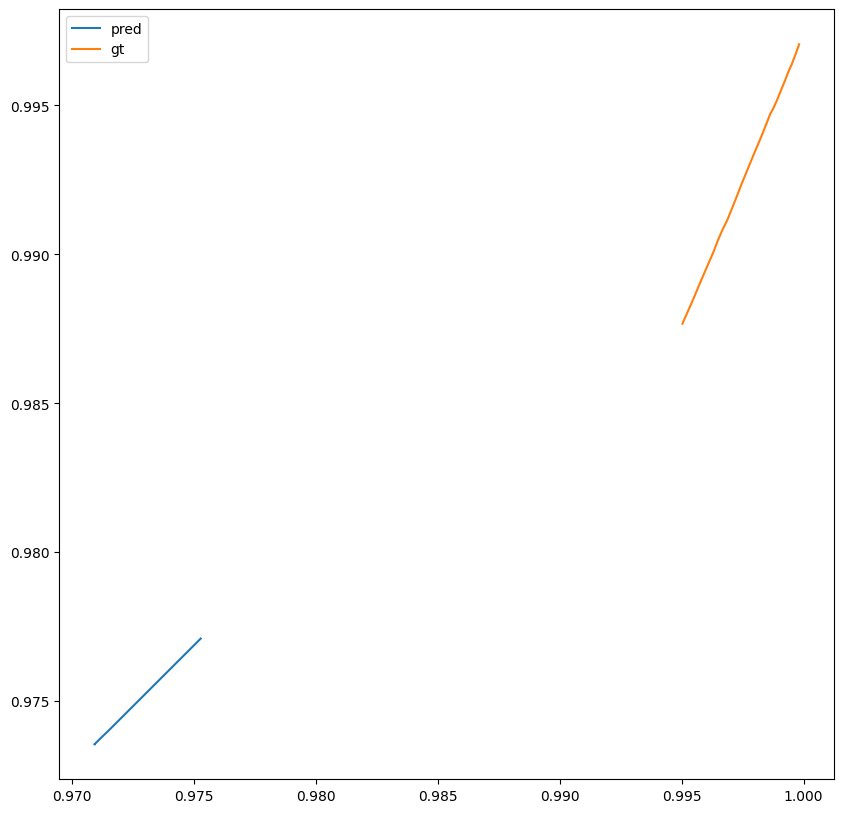

In [95]:
out_len = 30
baseline.eval()
out = []

with torch.no_grad():
    for i in range(1):
        out_test = LSTM_data[i]
        inp = torch.tensor(out_test).float().to(device)
        inp = inp.view(-1, seq_len, input_size)

        for j in range(out_len):
            pred = baseline(inp).to(device)
            inp = torch.cat((inp[:, 1:, :], pred[:, -1:, :]), dim=1)
            out_test = np.concatenate((out_test, pred[:, -1, :].cpu().numpy()), axis=0)
        out.append(out_test)

out = out[0][19:]
out = np.array(out)
out = out.reshape(-1, 2)
gt = []
for i in range(out_len):
    gt.append(LSTM_label[i][0])
gt = np.array(gt)
print(out.shape, gt.shape)

plt.figure(figsize=(10, 10))
plt.plot(out[:, 0], out[:, 1], label='pred')
plt.plot(gt[:-1, 0], gt[:-1, 1], label='gt')
plt.legend()
plt.show()

In [96]:
print(out)

[[0.97528327 0.97710395]
 [0.97157198 0.97406864]
 [0.97114062 0.97372663]
 [0.97104025 0.97364521]
 [0.97099626 0.97360891]
 [0.97097147 0.97358835]
 [0.97095633 0.97357583]
 [0.97094691 0.97356802]
 [0.97094113 0.97356319]
 [0.97093743 0.97356009]
 [0.97093511 0.97355813]
 [0.97093368 0.973557  ]
 [0.97093272 0.97355622]
 [0.97093225 0.97355574]
 [0.97093189 0.97355551]
 [0.97093171 0.97355533]
 [0.97093153 0.97355521]
 [0.97093153 0.97355515]
 [0.97093147 0.97355509]
 [0.97093147 0.97355509]
 [0.97093141 0.97355509]
 [0.97093135 0.97355509]
 [0.97093135 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]
 [0.97093141 0.97355509]]


In [12]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        lane_shape = []
        for i in range(len(self.pkl_list)):
            with open(self.pkl_list[i], 'rb') as f:
                scene = pickle.load(f)
                lane_shape.append(scene['lane'].shape[0])
        self.max_lane_len = max(lane_shape)
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
        
        # Normalization 
        min_vecs = scene['normalize_min']
        max_vecs = scene['normalize_max']
        
        # Normalize by vectors
        inp = scene['inp_scene'][:, :2]
        out = scene['out_scene']

        lane = scene['lane']
        normalize_lane = (lane - min_vecs[:2]) / (max_vecs[:2] - min_vecs[:2])
        normalize_lane = np.pad(normalize_lane, ((0, self.max_lane_len - normalize_lane.shape[0]), (0, 0)), 'constant', constant_values=0)
        inp = np.concatenate((inp, normalize_lane), axis=0)
        
        # Convert to float torch tensor
        return torch.from_numpy(inp).float(), torch.from_numpy(out[:,:2]).float()

In [14]:
class MLPNet(nn.Module):
    def __init__(self, 
                 in_dim, # input dimension
                 out_dim, # output dimension
                 hidden_dim, # hidden dimension
                 num_layers # number of layers
                ):
        
        super(MLPNet, self).__init__()
        
        self.model = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        
        for i in range(num_layers-2):
            self.model += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        
        self.model += [nn.Linear(hidden_dim, out_dim)]
        
        self.model = nn.Sequential(*self.model)
        
    def forward(self, inp):
        
        # Flatten the last two dimensions
        inp = inp.reshape(inp.shape[0], -1)
        
        out = self.model(inp)
        
        #bz x outputlength x 2
        return out.reshape(inp.shape[0], -1, 2)

In [18]:
# MLP hyperparamters
batch_size = 4096
in_dim = (1899 + 19) * 2
out_dim = 30*2
hidden_dim = 2048
num_layers = 7
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 5

In [19]:
train_path = "./../data/prep_1/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [20]:
model = MLPNet(in_dim = in_dim, 
               out_dim = out_dim,
               hidden_dim = hidden_dim, 
               num_layers = num_layers).to(device) # move model to gpu 

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [21]:
def l2_regularization(model, lambda_l2):
    l2_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    return lambda_l2 * l2_reg

def train_epoch(train_loader, model, optimizer, loss_function):
    model.train()
    train_mse = []
    i = 0
    for inp, tgt in train_loader:
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        pred = model(inp)
        plt.scatter(inp[0,:19,0].cpu().data.numpy(), inp[0,:19,1].cpu().data.numpy(), c='r')
        plt.scatter(tgt[0,:,0].cpu().data.numpy(), tgt[0,:,1].cpu().data.numpy(), c='b')
        plt.scatter(pred[0,:,0].cpu().data.numpy(), pred[0,:,1].cpu().data.numpy(), c='g')
        plt.savefig('./../../../../../cs_pr_data/train_plot/mlp_lane/{}.png'.format(i))
        plt.clf()
        loss = loss_function(pred, tgt)
        train_mse.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    valid_mse = []
    preds = []
    trues = []
    model.eval()
    i = 0
    with torch.no_grad():
        for inp, tgt in valid_loader:
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            pred = model(inp)

            plt.scatter(inp[0,:19,0].cpu().data.numpy(), inp[0,:19,1].cpu().data.numpy(), c='r')
            plt.scatter(tgt[0,:,0].cpu().data.numpy(), tgt[0,:,1].cpu().data.numpy(), c='b')
            plt.scatter(pred[0,:,0].cpu().data.numpy(), pred[0,:,1].cpu().data.numpy(), c='g')
            plt.savefig('./../../../../../cs_pr_data/val_plot/mlp_lane/{}.png'.format(i))
            plt.clf()

            loss = loss_function(pred, tgt)
            preds.append(pred.cpu().data.numpy())
            trues.append(tgt.cpu().data.numpy())
            valid_mse.append(loss.item())
            i += 1
            
        preds = np.concatenate(preds, axis = 0)  
        trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse, preds, trues

In [22]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in range(num_epoch):
    start = time.time()
    
    # Add regularization
    # model.train()
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    
    # train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun) + l2_regularization(model, 0.001))


    # model.eval()
    val_rmse, val_preds, val_trues = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27cc2554c0>
Traceback (most recent call last):
  File "/home/amm/Dropbox/SP23/CSE251B/project/scripts/project/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/amm/Dropbox/SP23/CSE251B/project/scripts/project/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27cc2554c0>
Traceback (most recent call last):
  File "/home/amm/Dropbox/SP23/CSE251B/project/scripts/project/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/amm/Dropb

Epoch 1 | T: 3.28 | Train RMSE: 5.78332 | Valid RMSE: 1.67074
Epoch 2 | T: 3.24 | Train RMSE: 0.63136 | Valid RMSE: 0.13143
Epoch 3 | T: 3.28 | Train RMSE: 0.07829 | Valid RMSE: 0.04765
Epoch 4 | T: 3.26 | Train RMSE: 0.04618 | Valid RMSE: 0.04563
Epoch 5 | T: 3.26 | Train RMSE: 0.04576 | Valid RMSE: 0.04560


<Figure size 640x480 with 0 Axes>

In [24]:
test_path = "./../data/prep_1/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()
test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        inp_scene = test_sample['inp_scene'][:, :2]
        max_lane_len = 1899

        # Normalization 
        min_vecs = test_sample['normalize_min']
        max_vecs = test_sample['normalize_max']

        lane = test_sample['lane']
        inp_lane = lane[:, :2]
        max_lane = max_vecs[:2]
        min_lane = min_vecs[:2]
        lane = (lane - min_lane) / (max_lane - min_lane)
        lane = np.pad(lane, ((0, max_lane_len - lane.shape[0]), (0, 0)), 'constant', constant_values=0)

        inp_scene = np.concatenate([inp_scene, lane], axis=0)
       
        inp = torch.from_numpy(inp_scene).float().to(device).unsqueeze(0)

        preds = best_model(inp).cpu().data.numpy()
        
        # De-Normalization ! 
        preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]

        p_out = preds.squeeze(0)
        p_in = (inp_scene[:19, :2] * (max_vecs[:2] - min_vecs[:2])) + min_vecs[:2]
        
        plt.scatter(p_in[:, 0], p_in[:, 1], c='b', s=1)
        plt.scatter(p_out[:, 0], p_out[:, 1], c='r', s=1)
        plt.scatter(inp_lane[:, 0], inp_lane[:, 1], c='g', s=1)

        plt.savefig("./../../../../../cs_pr_data/test_plot/mlp_lane/{}.png".format(idx))
        plt.clf()


        test_preds.append(preds)

        print("Test Sample: {}/{}".format(idx, len(test_pkl_list)))
        print("-"*50)

Test Sample: 0/3200
--------------------------------------------------
Test Sample: 1/3200
--------------------------------------------------
Test Sample: 2/3200
--------------------------------------------------
Test Sample: 3/3200
--------------------------------------------------
Test Sample: 4/3200
--------------------------------------------------
Test Sample: 5/3200
--------------------------------------------------
Test Sample: 6/3200
--------------------------------------------------
Test Sample: 7/3200
--------------------------------------------------
Test Sample: 8/3200
--------------------------------------------------
Test Sample: 9/3200
--------------------------------------------------
Test Sample: 10/3200
--------------------------------------------------
Test Sample: 11/3200
--------------------------------------------------
Test Sample: 12/3200
--------------------------------------------------
Test Sample: 13/3200
--------------------------------------------------
Te

<Figure size 640x480 with 0 Axes>

In [34]:
# # Submission Files
sample_sub = pd.read_csv('./../submissions/sample_submission.csv')

In [36]:
# Convert to int
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv('./../submissions/test_submission.csv', index=None)